# Hyperparameter tuning

To improve the performance of our model, we need to delve into the realm of hyperparameter tuning. Hyperparameters are settings that we can adjust to optimize the behavior and accuracy of our machine learning model, to fine-tune it's performance. 

The previous model was trained with certain default hyperparameter values, which serve as a baseline. However, these default values may not always yield the best results for our specific problem.

Hyperparameter tuning involves systematically exploring different combinations of hyperparameter values to find the optimal configuration that maximizes our model's performance. This process is often iterative and involves training and evaluating the model multiple times with different hyperparameter settings.

In [1]:
import sys
sys.path.insert(0, './src')
import utils



import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning) # Masks are not georeferences, so we can ignore this warning
warnings.filterwarnings("ignore", category=UserWarning) # This will throw a warning message about cudnn, this is normal (https://github.com/pytorch/pytorch/pull/125790)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
# MEAN = [63.02235933, 66.64201154, 60.63862196]
# STD = [55.50368184, 55.35826425, 52.63471437]
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
MAX_LR = 1e-3
TRAIN_SIZE = 320
VAL_SIZE = 360
NUM_WORKERS = 4
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
EPOCHS = 80
LOAD_BEST = True
NAME = "2 - LR1e-3 TrainBatch8 Epoch24 noScheduler"

DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
DATA_PATH = OUTPUT_PATH + "data/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"

We'll reimport the default values that we had from before

We slightly modified the values of the transformations! We're having a better alignment, and using A.RandomCrop is better than A.Resize because you don't loose details

Using PyTorch version: 2.3.0+cu121  Device: cuda
PyTorch version:  2.3.0+cu121
CUDA version:  12.1
cuDNN version:  8902
Image shape: torch.Size([8, 3, 320, 320]), Mask shape: torch.Size([8, 1, 320, 320])


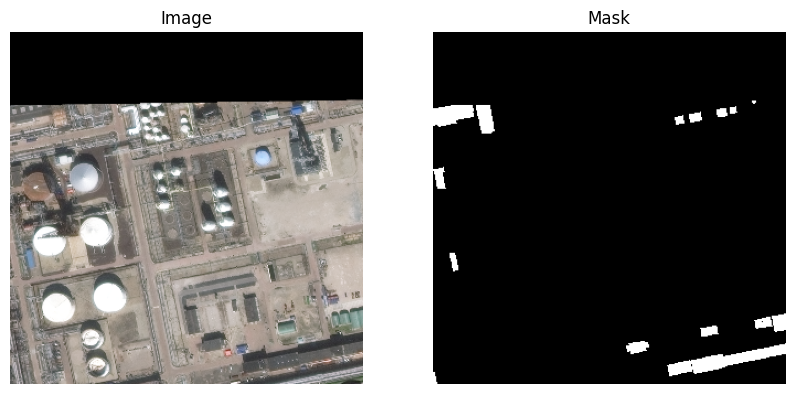

In [3]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())


train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(896, 896),
    A.RandomCrop(TRAIN_SIZE, TRAIN_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomCrop(896, 896),
    A.Resize(VAL_SIZE, VAL_SIZE)
])
from dataset import SN6Dataset

train_dataset = SN6Dataset(DATASET_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='val')
test_dataset = SN6Dataset(DATASET_PATH, transform=eval_transforms, split='test')

train_loader = data.DataLoader(train_dataset, pin_memory = True, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
eval_loader = data.DataLoader(eval_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image, mask = next(iter(train_loader))
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
utils.visualize_image(image[0], mask[0])

We'll be trying something new: A custom loss function that connects both BCEWithLogitLoss and a custom-made Dice loss (since we already established it's our best parameter) in a 50/50 mix. It's been implemented in _custom_loss.py_

we'll try to work on 
 - Normalization
 - A better Segmentation
 - Maybe slowing down the learning rate even further
 

In [4]:
from model import UNET

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR, weight_decay=1e-5)

# We won't use a scheduler at first, but we'll add it later
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scaler = torch.cuda.amp.GradScaler()


One of the things I've noticed in the training is how hard it's for the model to track small buildings, this is because to make our batch_size higher a downscale was necessary; we modified some values, changing:
 - SIZE to 300x300
 - BATCH_SIZE to 8

In [5]:
from train import train

best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'last_epoch': 0 
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + f"best_{NAME}.pth")):
        history = utils.load_checkpoint(CHECKPOINT_PATH + f"best_{NAME}.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
        last_epoch = history['last_epoch']
        print(f"Best model found, starting from epoch {last_epoch+1} with f1_score {best_f1}")
    else:
        print("Best model not found, starting from scratch")

# Training model
for epoch in range(last_epoch, EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
    # Detect if loss is NaN, and immediately stop with a ValueError 
    
    
    eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path=DATA_PATH)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(eval_loss)
    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['accuracy'].append(accuracy)
    history['last_epoch'] = epoch
    print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
    # Save model
    checkpoint = {
        "history" : history,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": criterion.state_dict(),
    }
    utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"checkpoint_{NAME}.pth")
    if f1 > best_f1:
        best_f1 = f1
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + f"best_{NAME}.pth")
        print("Best model saved")

    if epoch - 5 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
        if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2] > history['val_loss'][epoch-3] > history['val_loss'][epoch-4]:
            print("Early stopping")
            break
print("Finished training! Well done :3\nQuitting...")

Restoring best model
Best model not found, starting from scratch
Epoch 1 of 80


Loss: 0.4823: 100%|██████████| 340/340 [01:42<00:00,  3.33it/s]

Saving predictions to: output/data/


Train loss: 0.5956 Eval loss: 0.4866 Precision: 0.3464 Recall: 0.6569 F1: 0.4536 Accuracy: 0.8924
saving checkpoint
saving checkpoint
Best model saved
Epoch 2 of 80


Loss: 0.3682: 100%|██████████| 340/340 [01:42<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.4227 Eval loss: 0.3720 Precision: 0.6130 Recall: 0.6094 F1: 0.6112 Accuracy: 0.9473
saving checkpoint
saving checkpoint
Best model saved
Epoch 3 of 80


Loss: 0.3485: 100%|██████████| 340/340 [01:47<00:00,  3.15it/s]

Saving predictions to: output/data/


Train loss: 0.3656 Eval loss: 0.3324 Precision: 0.7584 Recall: 0.5707 F1: 0.6513 Accuracy: 0.9585
saving checkpoint
saving checkpoint
Best model saved
Epoch 4 of 80


Loss: 0.3248: 100%|██████████| 340/340 [01:42<00:00,  3.32it/s]

Saving predictions to: output/data/


Train loss: 0.3385 Eval loss: 0.3110 Precision: 0.7096 Recall: 0.7092 F1: 0.7094 Accuracy: 0.9605
saving checkpoint
saving checkpoint
Best model saved
Epoch 5 of 80


Loss: 0.3145: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.3147 Eval loss: 0.2959 Precision: 0.6742 Recall: 0.7613 F1: 0.7151 Accuracy: 0.9588
saving checkpoint
saving checkpoint
Best model saved
Epoch 6 of 80


Loss: 0.2712: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.2912 Eval loss: 0.2796 Precision: 0.8215 Recall: 0.6496 F1: 0.7255 Accuracy: 0.9666
saving checkpoint
saving checkpoint
Best model saved
Epoch 7 of 80


Loss: 0.2632: 100%|██████████| 340/340 [01:58<00:00,  2.86it/s]

Saving predictions to: output/data/


Train loss: 0.2646 Eval loss: 0.2451 Precision: 0.6999 Recall: 0.8199 F1: 0.7552 Accuracy: 0.9639
saving checkpoint
saving checkpoint
Best model saved
Epoch 8 of 80


Loss: 0.2185: 100%|██████████| 340/340 [01:42<00:00,  3.33it/s]

Saving predictions to: output/data/


Train loss: 0.2366 Eval loss: 0.2127 Precision: 0.7979 Recall: 0.7520 F1: 0.7743 Accuracy: 0.9702
saving checkpoint
saving checkpoint
Best model saved
Epoch 9 of 80


Loss: 0.1933: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.2056 Eval loss: 0.1867 Precision: 0.8844 Recall: 0.7124 F1: 0.7891 Accuracy: 0.9741
saving checkpoint
saving checkpoint
Best model saved
Epoch 10 of 80


Loss: 0.1702: 100%|██████████| 340/340 [01:44<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.1840 Eval loss: 0.1658 Precision: 0.8997 Recall: 0.6686 F1: 0.7672 Accuracy: 0.9724
saving checkpoint
Epoch 11 of 80


Loss: 0.1319: 100%|██████████| 340/340 [01:43<00:00,  3.28it/s]

Saving predictions to: output/data/


Train loss: 0.1516 Eval loss: 0.1366 Precision: 0.9049 Recall: 0.7370 F1: 0.8123 Accuracy: 0.9769
saving checkpoint
saving checkpoint
Best model saved
Epoch 12 of 80


Loss: 0.1166: 100%|██████████| 340/340 [01:43<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.1237 Eval loss: 0.1114 Precision: 0.8461 Recall: 0.8254 F1: 0.8356 Accuracy: 0.9779
saving checkpoint
saving checkpoint
Best model saved
Epoch 13 of 80


Loss: 0.0868: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.1040 Eval loss: 0.1025 Precision: 0.9254 Recall: 0.7256 F1: 0.8134 Accuracy: 0.9774
saving checkpoint
Epoch 14 of 80


Loss: 0.0798: 100%|██████████| 340/340 [01:42<00:00,  3.32it/s]

Saving predictions to: output/data/


Train loss: 0.0856 Eval loss: 0.0783 Precision: 0.8971 Recall: 0.8204 F1: 0.8571 Accuracy: 0.9814
saving checkpoint
saving checkpoint
Best model saved
Epoch 15 of 80


Loss: 0.0809: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0680 Eval loss: 0.0652 Precision: 0.9059 Recall: 0.8229 F1: 0.8624 Accuracy: 0.9822
saving checkpoint
saving checkpoint
Best model saved
Epoch 16 of 80


Loss: 0.0474: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0694 Eval loss: 0.0643 Precision: 0.9035 Recall: 0.8148 F1: 0.8569 Accuracy: 0.9815
saving checkpoint
Epoch 17 of 80


Loss: 0.0457: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0526 Eval loss: 0.0532 Precision: 0.9157 Recall: 0.8333 F1: 0.8726 Accuracy: 0.9835
saving checkpoint
saving checkpoint
Best model saved
Epoch 18 of 80


Loss: 0.0272: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0444 Eval loss: 0.0480 Precision: 0.8900 Recall: 0.8755 F1: 0.8827 Accuracy: 0.9842
saving checkpoint
saving checkpoint
Best model saved
Epoch 19 of 80


Loss: 0.0710: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0481 Eval loss: 0.0528 Precision: 0.9047 Recall: 0.8162 F1: 0.8581 Accuracy: 0.9817
saving checkpoint
Epoch 20 of 80


Loss: 0.0475: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0410 Eval loss: 0.0420 Precision: 0.9153 Recall: 0.8605 F1: 0.8871 Accuracy: 0.9851
saving checkpoint
saving checkpoint
Best model saved
Epoch 21 of 80


Loss: 0.0342: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0336 Eval loss: 0.0401 Precision: 0.9356 Recall: 0.8479 F1: 0.8896 Accuracy: 0.9857
saving checkpoint
saving checkpoint
Best model saved
Epoch 22 of 80


Loss: 0.0493: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0307 Eval loss: 0.0380 Precision: 0.9300 Recall: 0.8605 F1: 0.8939 Accuracy: 0.9861
saving checkpoint
saving checkpoint
Best model saved
Epoch 23 of 80


Loss: 0.0669: 100%|██████████| 340/340 [01:41<00:00,  3.34it/s]

Saving predictions to: output/data/


Train loss: 0.0365 Eval loss: 0.0722 Precision: 0.8823 Recall: 0.6849 F1: 0.7711 Accuracy: 0.9724
saving checkpoint
Epoch 24 of 80


Loss: 0.0378: 100%|██████████| 340/340 [01:43<00:00,  3.30it/s]

Saving predictions to: output/data/


Train loss: 0.0459 Eval loss: 0.0374 Precision: 0.9195 Recall: 0.8630 F1: 0.8904 Accuracy: 0.9856
saving checkpoint
Epoch 25 of 80


Loss: 0.0155: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0275 Eval loss: 0.0349 Precision: 0.9282 Recall: 0.8694 F1: 0.8978 Accuracy: 0.9866
saving checkpoint
saving checkpoint
Best model saved
Epoch 26 of 80


Loss: 0.0331: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0246 Eval loss: 0.0314 Precision: 0.9215 Recall: 0.8951 F1: 0.9081 Accuracy: 0.9877
saving checkpoint
saving checkpoint
Best model saved
Epoch 27 of 80


Loss: 0.0233: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0233 Eval loss: 0.0340 Precision: 0.9298 Recall: 0.8746 F1: 0.9014 Accuracy: 0.9870
saving checkpoint
Epoch 28 of 80


Loss: 0.0255: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0223 Eval loss: 0.0345 Precision: 0.9346 Recall: 0.8664 F1: 0.8992 Accuracy: 0.9868
saving checkpoint
Epoch 29 of 80


Loss: 0.0598: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0288 Eval loss: 0.0805 Precision: 0.8919 Recall: 0.6402 F1: 0.7454 Accuracy: 0.9703
saving checkpoint
Epoch 30 of 80


Loss: 0.0327: 100%|██████████| 340/340 [01:41<00:00,  3.37it/s]

Saving predictions to: output/data/


Train loss: 0.0343 Eval loss: 0.0338 Precision: 0.9119 Recall: 0.8872 F1: 0.8994 Accuracy: 0.9865
saving checkpoint
Epoch 31 of 80


Loss: 0.0352: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0242 Eval loss: 0.0300 Precision: 0.9273 Recall: 0.8968 F1: 0.9118 Accuracy: 0.9882
saving checkpoint
saving checkpoint
Best model saved
Epoch 32 of 80


Loss: 0.0075: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0198 Eval loss: 0.0329 Precision: 0.9424 Recall: 0.8690 F1: 0.9042 Accuracy: 0.9875
saving checkpoint
Epoch 33 of 80


Loss: 0.0112: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0187 Eval loss: 0.0315 Precision: 0.9366 Recall: 0.8860 F1: 0.9106 Accuracy: 0.9882
saving checkpoint
Epoch 34 of 80


Loss: 0.0086: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0178 Eval loss: 0.0305 Precision: 0.9407 Recall: 0.8852 F1: 0.9121 Accuracy: 0.9884
saving checkpoint
saving checkpoint
Best model saved
Epoch 35 of 80


Loss: 0.0218: 100%|██████████| 340/340 [01:41<00:00,  3.36it/s]

Saving predictions to: output/data/


Train loss: 0.0175 Eval loss: 0.0295 Precision: 0.9293 Recall: 0.9032 F1: 0.9161 Accuracy: 0.9888
saving checkpoint
saving checkpoint
Best model saved
Epoch 36 of 80


Loss: 0.0096: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0168 Eval loss: 0.0332 Precision: 0.9355 Recall: 0.8813 F1: 0.9076 Accuracy: 0.9878
saving checkpoint
Epoch 37 of 80


Loss: 0.0178: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0168 Eval loss: 0.0330 Precision: 0.9323 Recall: 0.8814 F1: 0.9061 Accuracy: 0.9876
saving checkpoint
Epoch 38 of 80


Loss: 0.0151: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0381 Eval loss: 0.0318 Precision: 0.9195 Recall: 0.8927 F1: 0.9059 Accuracy: 0.9874
saving checkpoint
Epoch 39 of 80


Loss: 0.0168: 100%|██████████| 340/340 [01:55<00:00,  2.93it/s]

Saving predictions to: output/data/


Train loss: 0.0189 Eval loss: 0.0282 Precision: 0.9331 Recall: 0.9053 F1: 0.9190 Accuracy: 0.9892
saving checkpoint
saving checkpoint
Best model saved
Epoch 40 of 80


Loss: 0.0183: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0158 Eval loss: 0.0285 Precision: 0.9279 Recall: 0.9133 F1: 0.9206 Accuracy: 0.9893
saving checkpoint
saving checkpoint
Best model saved
Epoch 41 of 80


Loss: 0.0109: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0148 Eval loss: 0.0297 Precision: 0.9344 Recall: 0.9043 F1: 0.9191 Accuracy: 0.9892
saving checkpoint
Epoch 42 of 80


Loss: 0.0095: 100%|██████████| 340/340 [01:41<00:00,  3.35it/s]

Saving predictions to: output/data/


Train loss: 0.0145 Eval loss: 0.0291 Precision: 0.9383 Recall: 0.9030 F1: 0.9203 Accuracy: 0.9894
saving checkpoint
Epoch 43 of 80


Loss: 0.0120: 100%|██████████| 340/340 [01:42<00:00,  3.31it/s]

Saving predictions to: output/data/


Train loss: 0.0140 Eval loss: 0.0335 Precision: 0.9427 Recall: 0.8841 F1: 0.9124 Accuracy: 0.9885
saving checkpoint
Epoch 44 of 80


Loss: 0.0184: 100%|██████████| 340/340 [01:44<00:00,  3.26it/s]

Saving predictions to: output/data/


Train loss: 0.0138 Eval loss: 0.0307 Precision: 0.9404 Recall: 0.8967 F1: 0.9180 Accuracy: 0.9891
saving checkpoint
Epoch 45 of 80


Loss: 0.0143: 100%|██████████| 340/340 [01:44<00:00,  3.27it/s]

Saving predictions to: output/data/


Train loss: 0.0133 Eval loss: 0.0304 Precision: 0.9382 Recall: 0.9047 F1: 0.9212 Accuracy: 0.9895
saving checkpoint
saving checkpoint
Best model saved
Epoch 46 of 80


Loss: 0.0027:   5%|▍         | 16/340 [00:06<02:03,  2.63it/s]


KeyboardInterrupt: 

loading checkpoint


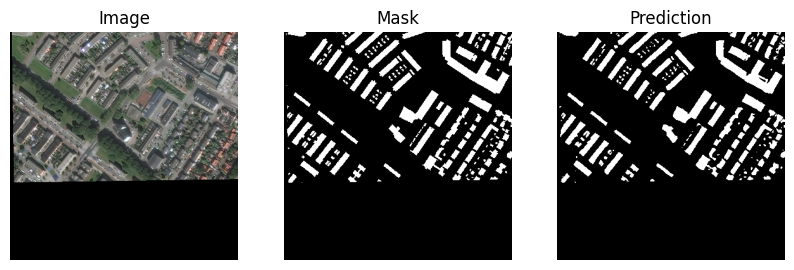

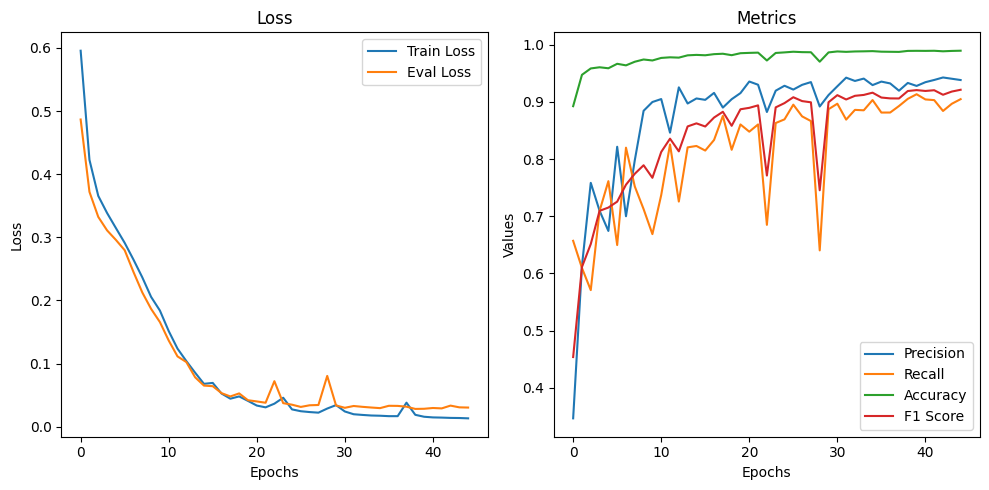

In [6]:
import matplotlib.pyplot as plt

# Get the history
history = utils.load_checkpoint(CHECKPOINT_PATH + f"checkpoint_{NAME}.pth", model)
image, mask, pred = utils.get_random_image(eval_loader, model, device)
utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + f"image_{NAME}.png")

train_loss = history['train_loss']
eval_loss = history['val_loss']
precision = history['precision']
recall = history['recall']
accuracy = history['accuracy']
f1_score = history['f1']
# Plot the loss and other metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Metrics')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(accuracy, label='Accuracy')
plt.plot(f1_score, label='F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig(GRAPH_PATH + f"metrics_{NAME}.png")
plt.show()